In [ ]:
from google.colab import files
uploaded = files.upload()

Saving UTKFace.zip to UTKFace (1).zip


In [ ]:
!ls -lh


total 234M
-rw-r--r-- 1 root root  69K Aug 27 05:12  model.png
drwxr-xr-x 1 root root 4.0K Aug 22 13:37  sample_data
drwxr-xr-x 3 root root 4.0K Aug 27 05:04  UTKFace
-rw-r--r-- 1 root root 117M Aug 27 05:24 'UTKFace (1).zip'
-rw-r--r-- 1 root root 117M Aug 27 05:04  UTKFace.zip


In [ ]:
!unzip -q 'UTKFace.zip' -d /content/UTKFace


replace /content/UTKFace/UTKFace/100_0_0_20170112213500903.jpg.chip.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!ls /content/UTKFace | head -20


UTKFace


In [ ]:
!find /content/UTKFace -type f | wc -l


23708


**Import Modules**

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

**Load the Dataset**

In [ ]:
BASE_DIR = '/content/UTKFace/UTKFace'


In [ ]:
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        try:
            temp = filename.split('_')
            age = int(temp[0])
            gender = int(temp[1])
            image_path = os.path.join(BASE_DIR, filename)

            image_paths.append(image_path)
            age_labels.append(age)
            gender_labels.append(gender)
        except Exception as e:
            print(f"Skipping file {filename} due to error: {e}")

print(f"Total images processed: {len(image_paths)}")


  0%|          | 0/23708 [00:00<?, ?it/s]

Total images processed: 23708


**DataFrame**


In [ ]:
df = pd.DataFrame({
    'image': image_paths,
    'age': age_labels,
    'gender': gender_labels
})

df.head()


image  age  gender
0  /content/UTKFace/UTKFace/36_1_0_20170117183326...   36       1
1  /content/UTKFace/UTKFace/50_0_0_20170117152322...   50       0
2  /content/UTKFace/UTKFace/2_0_4_201612211951557...    2       0
3  /content/UTKFace/UTKFace/24_1_2_20170116174412...   24       1
4  /content/UTKFace/UTKFace/61_0_3_20170105180813...   61       0

In [ ]:
gender_dict = {0:'Male', 1:'Female'}

**Exploratory Data Analysis**

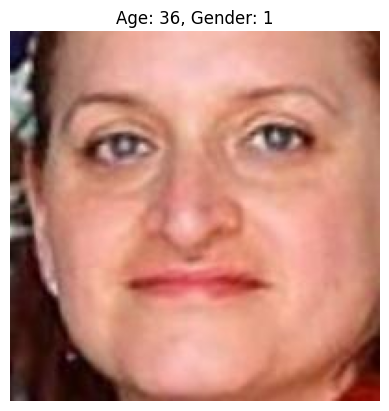

In [ ]:
from PIL import Image

img = Image.open(df['image'].iloc[0])
plt.axis('off')
plt.imshow(img)
plt.title(f"Age: {df['age'].iloc[0]}, Gender: {df['gender'].iloc[0]}")
plt.show()

<Axes: xlabel='age', ylabel='Density'>

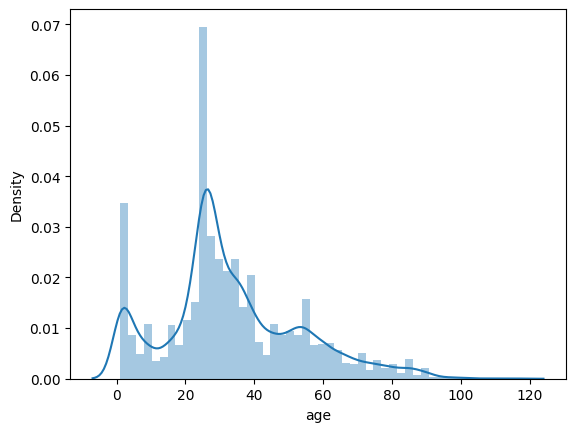

In [ ]:
sns.distplot(df['age'])


**Gender Labels**

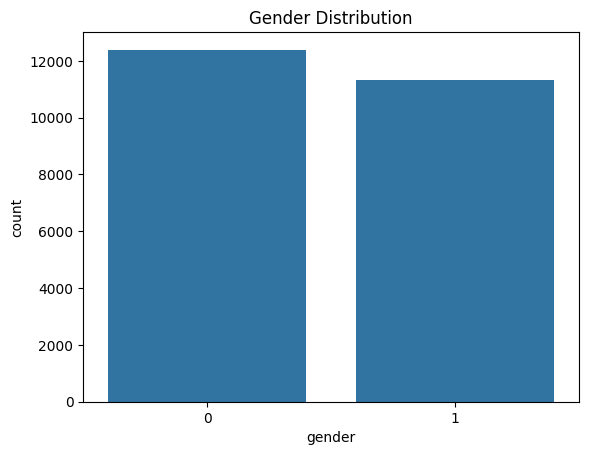

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='gender', data=df)

plt.xticks([0, 1], ['0', '1'])

plt.title('Gender Distribution')
plt.show()




**Display grid of Images**

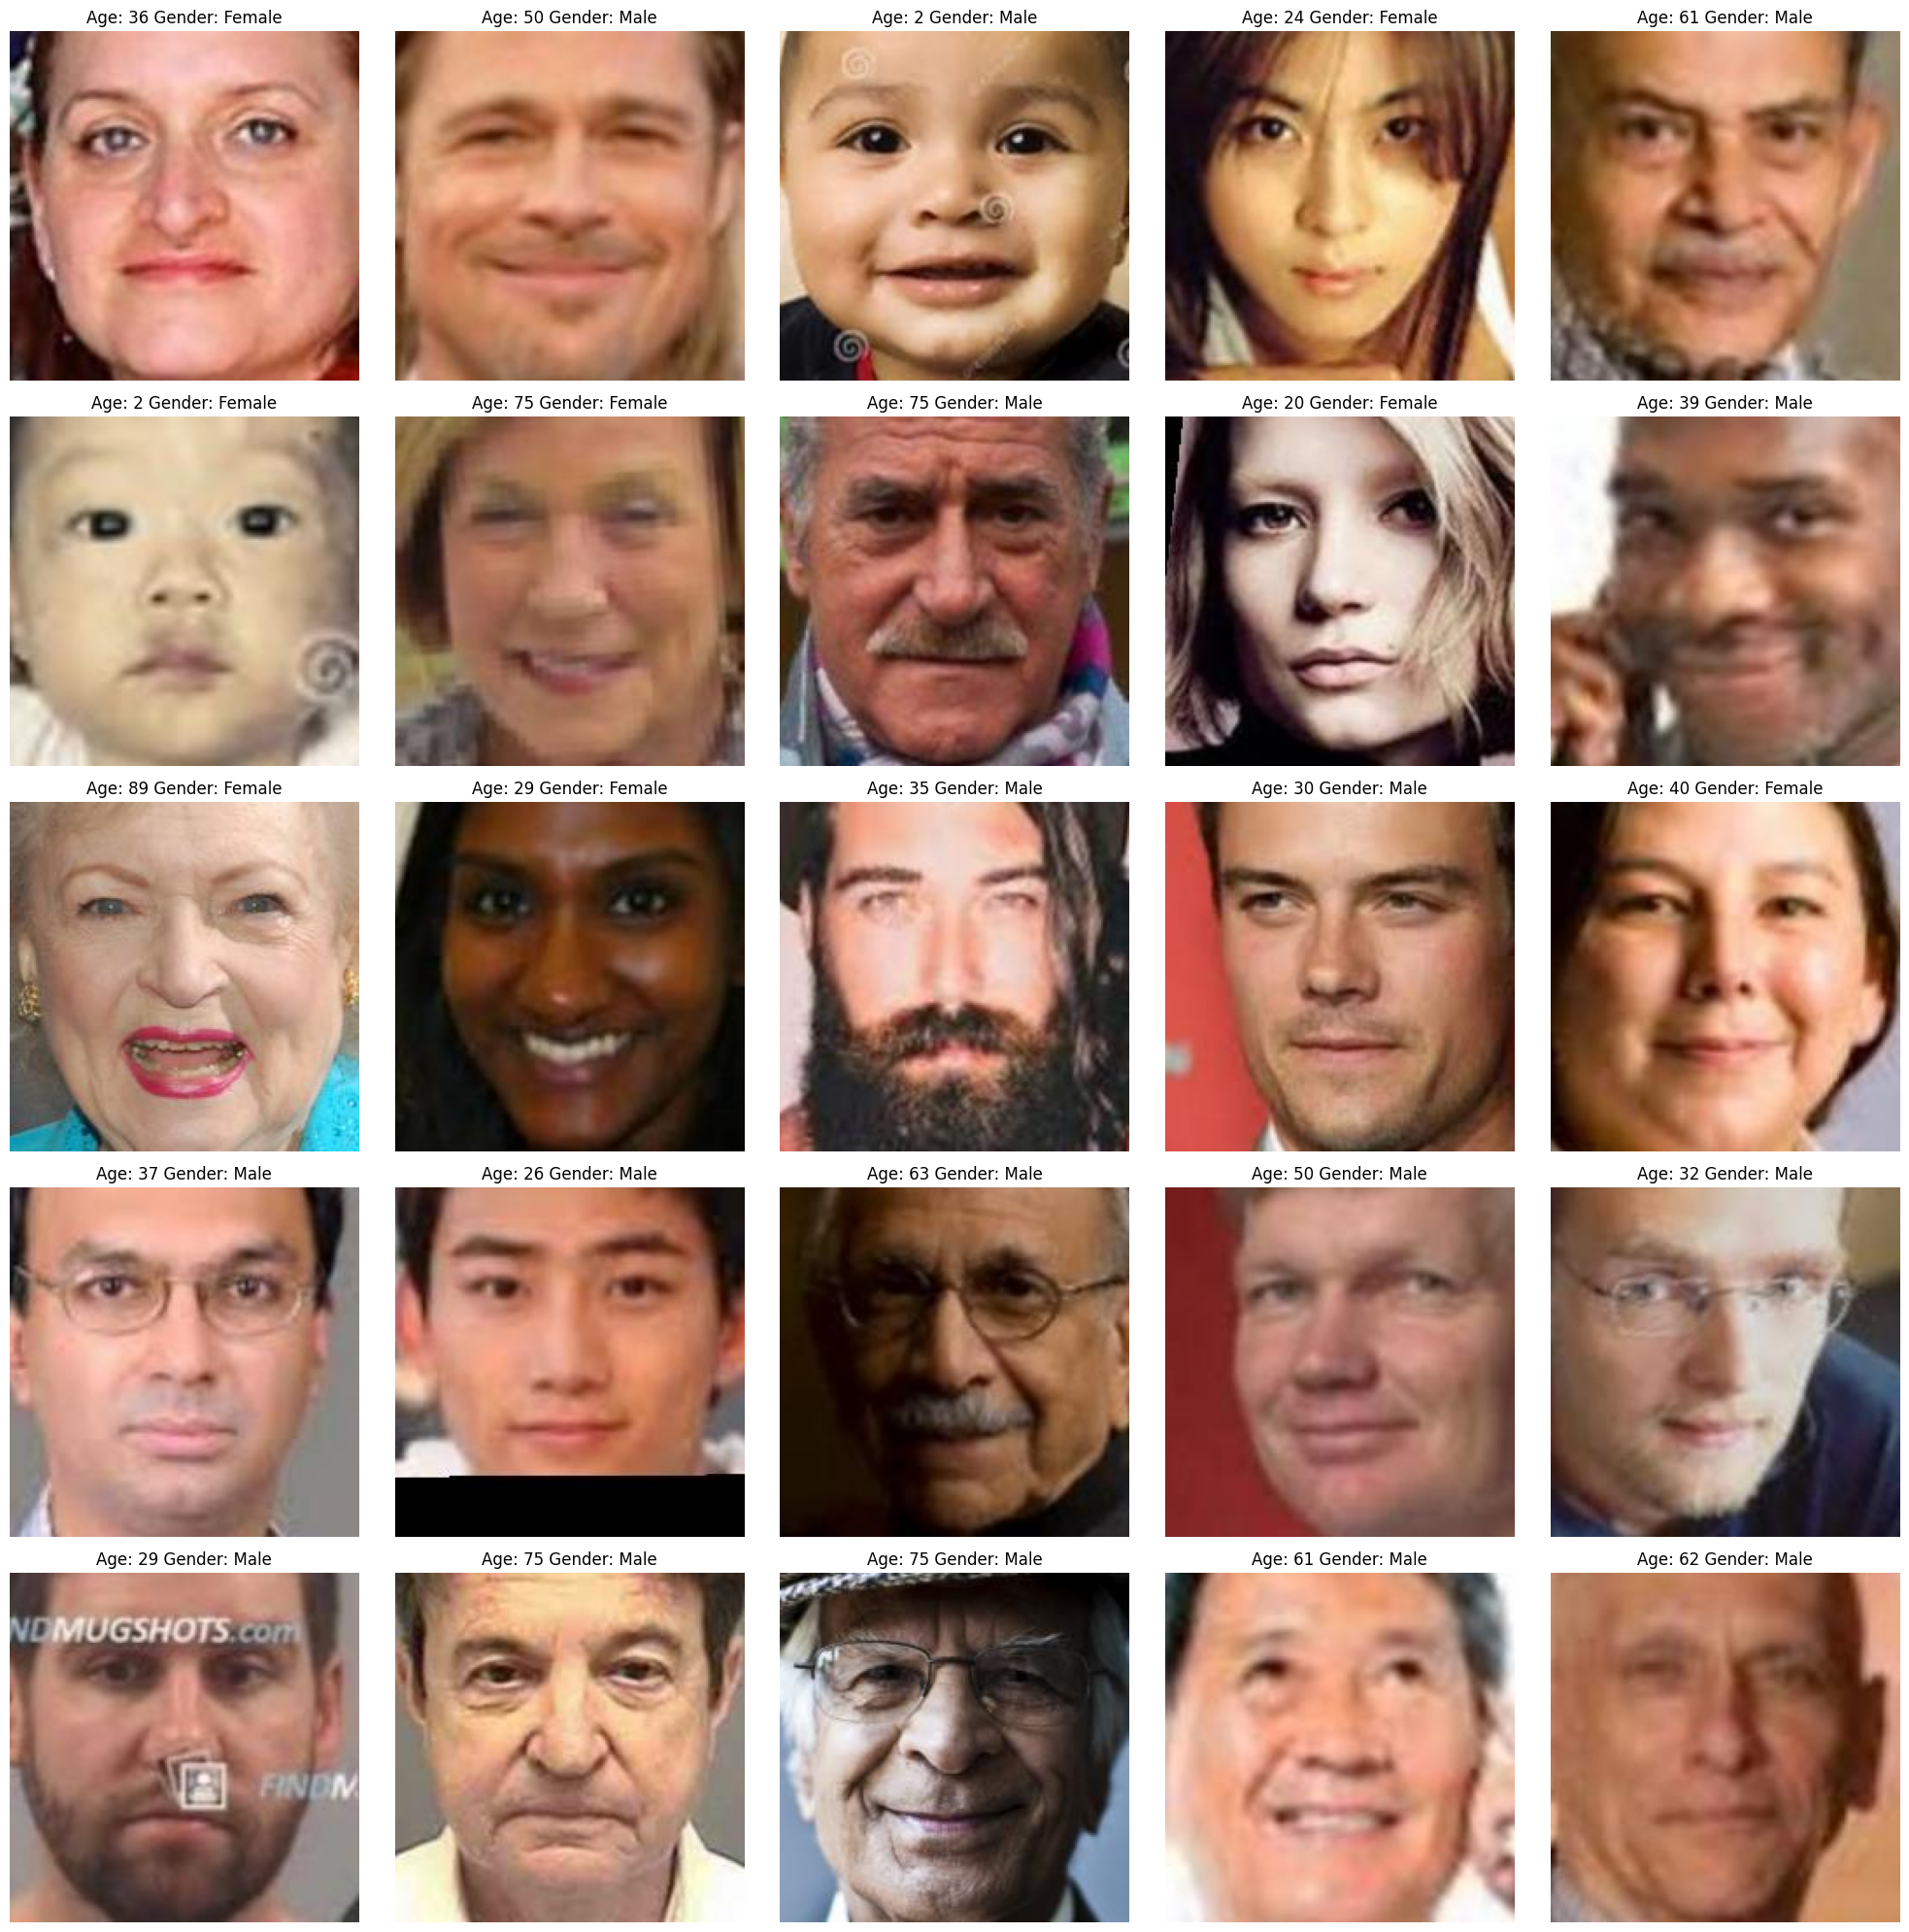

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img

plt.figure(figsize=(20, 20))
files = df.iloc[0:25]
gender_dict = {0: 'Male', 1: 'Female'}

for idx, row in enumerate(files.itertuples()):
    plt.subplot(5, 5, idx + 1)
    img = load_img(row.image)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {row.age} Gender: {gender_dict[row.gender]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

**Feature Extraction**


In [ ]:
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm
from keras.preprocessing.image import load_img

def extract_features_grayscale(images, target_size=(128,128)):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale', target_size=target_size)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    #reshape
    features = features.reshape(len(features), target_size[0], target_size[1], 1)
    return features


In [ ]:
X = extract_features_grayscale(df['image'].tolist())


  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
X.shape

(23708, 128, 128, 1)

**Normalize the image**

In [ ]:
X = X/255.0

In [ ]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [ ]:
input_shape = (128, 128, 1)

**Model Creation/CNN Model**

In [ ]:
inputs = Input((input_shape))
#convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

#fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])

**Plot the Model**

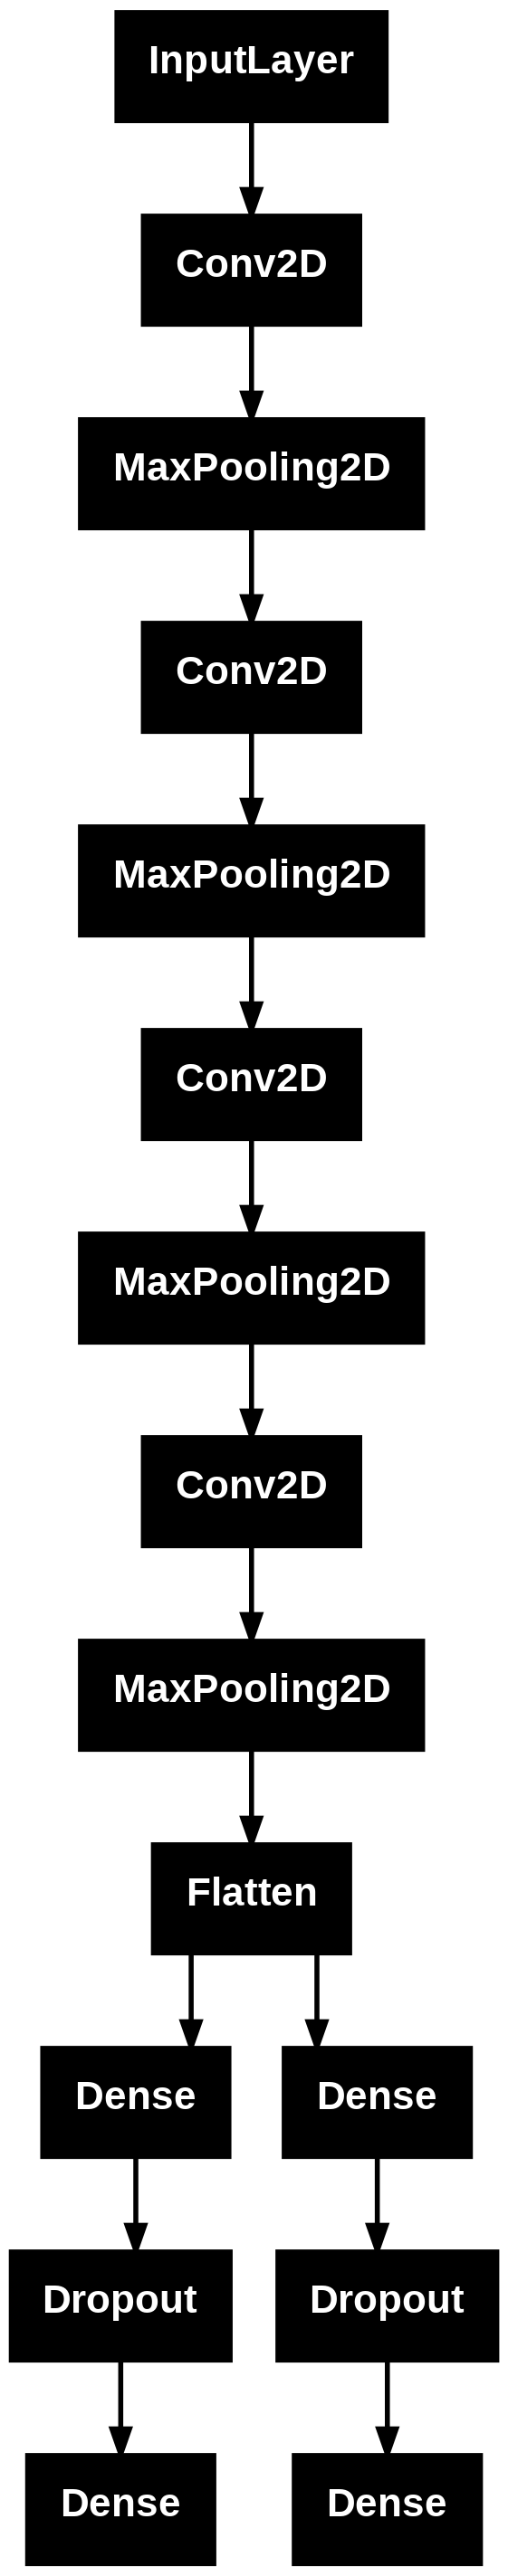

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

**Train Model**

In [ ]:

history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 694s 1s/step - age_out_loss: 17.3408 - age_out_mae: 17.3408 - gender_out_accuracy: 0.5233 - gender_out_loss: 0.7114 - loss: 18.0522 - val_age_out_loss: 13.5871 - val_age_out_mae: 13.5644 - val_gender_out_accuracy: 0.7143 - val_gender_out_loss: 0.5592 - val_loss: 14.1233
Epoch 2/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 701s 1s/step - age_out_loss: 11.5513 - age_out_mae: 11.5513 - gender_out_accuracy: 0.7472 - gender_out_loss: 0.5097 - loss: 12.0610 - val_age_out_loss: 10.3541 - val_age_out_mae: 10.3486 - val_gender_out_accuracy: 0.7893 - val_gender_out_loss: 0.4325 - val_loss: 10.7808
Epoch 3/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 692s 1s/step - age_out_loss: 9.5865 - age_out_mae: 9.5865 - gender_out_accuracy: 0.8100 - gender_out_loss: 0.4120 - loss: 9.9986 - val_age_out_loss: 8.3760 - val_age_out_mae: 8.3907 - val_gender_out_accuracy: 0.8153 - val_gender_out_loss: 0.3877 - val_loss: 8.7780
Epoch 4/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 743s 1s/step - age_out_loss: 8.55

**Results for Age and Gender**

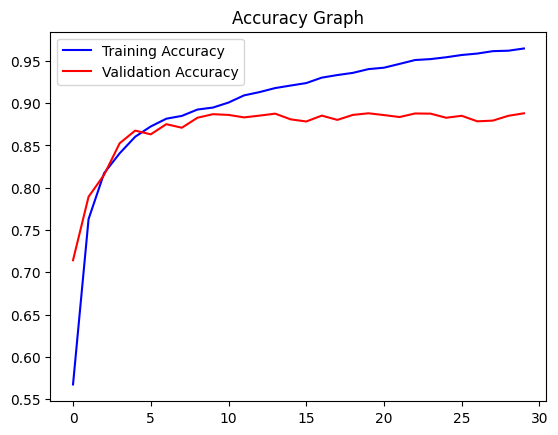

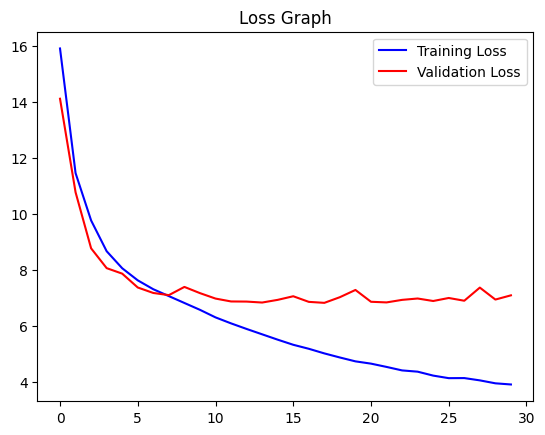

In [ ]:
#Gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()


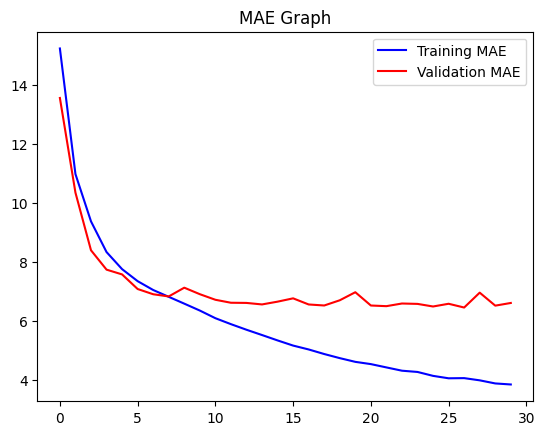

In [ ]:
#age
loss = history.history['age_out_mae']
val_loss = history.history['val_age_out_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('MAE Graph')
plt.legend()
plt.show()


**Predict Model**

Original Gender: Female Original Age: 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Predicted Gender: Female Predicted Age: 8


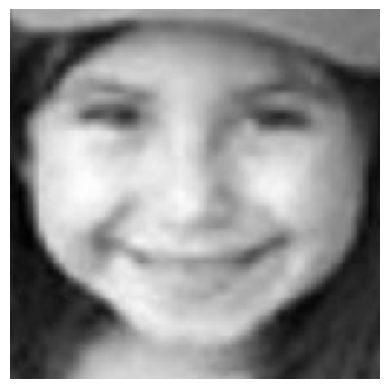

In [ ]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted Gender: Male Predicted Age: 53


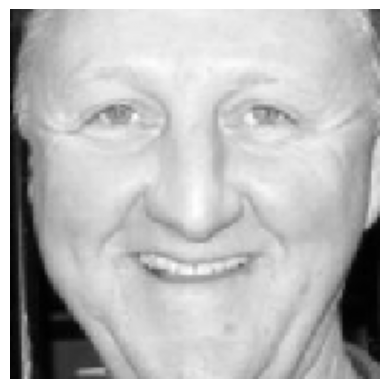

In [ ]:
image_index = 3000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])

pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
Predicted Gender: Female Predicted Age: 36


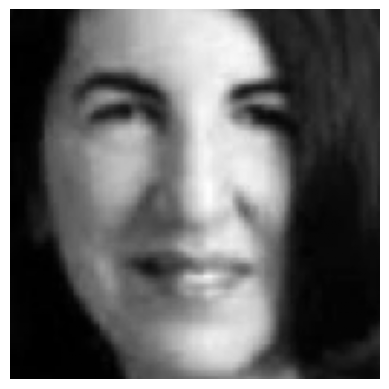

In [ ]:
image_index = 10000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])

pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');